In [11]:
import os
import sys
topFolder = os.getcwd().split('\\').pop(-1)
moduleDirectory = os.getcwd()[:-len(topFolder)]
sys.path.append(moduleDirectory)

from reporting import *
%matplotlib inline
import matplotlib.pyplot as plt

path = r'C:\Users\ucqba01\Documents\Local Data\Round 6'
dbGeneric = 'hR_m_2002_waves(waves)_RPS(rps)_fcost(fcost)_newfuelcost.db'

def makedbName(dbgeneric,labelDict):
    dbstring = dbgeneric
    for param in labelDict.keys():
        dbstring = dbstring.replace(param,str(labelDict[param]))
    return dbstring

testdb = makedbName(dbGeneric,{'(rps)':'90','(waves)':'10000','(fcost)':'120'})
vrelist = ['Solar','Windonshore','Windoffshore_Shallow','Windoffshore_Mid','Windoffshore_Floating']

fcost=[80,100,120,140]
waves=[400,10000]
RPS = [20,40,60,80,90,95]
columnList = ['vre_total','residual_load_vre']
paramsList = ['fcost','waves','rps','metric']

metrics = ['mean','std','min','max','50%']
statisticalValues = pd.DataFrame(columns=paramsList+columnList,index=np.arange(len(fcost)*len(waves)*len(RPS)*len(metrics)))
i=0
for fc in fcost:
    for w in waves:
        for rps in RPS:
            db = makedbName(dbGeneric,{'(rps)':str(rps),'(waves)':str(w),'(fcost)':str(fc)})
            con = sq.connect(path+'\\'+db)
            gen_sum_h = mergeGEN('var_vre_gen_sum_h','var_non_vre_gen_sum_h',con).set_index('h').pivot(columns='gen').xs('value',axis=1,drop_level=True)
            gen_sum_h['vre_total'] = gen_sum_h[vrelist].sum(axis=1)
            demand = get('demand',con).set_index('h').pivot(columns='z').sum(axis=1)
            gen_sum_h['demand'] = demand
            gen_sum_h['residual_load_vre'] = gen_sum_h['demand']-gen_sum_h['vre_total']
            data = gen_sum_h.describe()
            for met in metrics:
                metData = data.loc[met][columnList]
                paramseries = pd.Series(index=paramsList,data=[fc,w,rps,met])
                statisticalValues.loc[i]=paramseries.append(metData)
                i=i+1
            #print(statisticalValues)
print(statisticalValues)


    fcost  waves rps metric vre_total residual_load_vre
0      80    400  20   mean   12313.2           45157.1
1      80    400  20    std   5866.34           10574.3
2      80    400  20    min   235.268           29154.2
3      80    400  20    max   24914.5           86646.7
4      80    400  20    50%   12376.2           44384.3
5      80    400  40   mean   24030.3           33440.1
6      80    400  40    std   8644.59           10544.1
7      80    400  40    min   3159.79           16395.9
8      80    400  40    max   43356.8           80072.6
9      80    400  40    50%   24024.3           31779.6
10     80    400  60   mean   35721.2           21749.1
11     80    400  60    std   10836.7           10539.9
12     80    400  60    min   4861.45           3482.04
13     80    400  60    max     67213           74673.5
14     80    400  60    50%   36004.2             18336
15     80    400  80   mean   47570.7           9899.59
16     80    400  80    std   13071.4           

residual loads do not consider storage


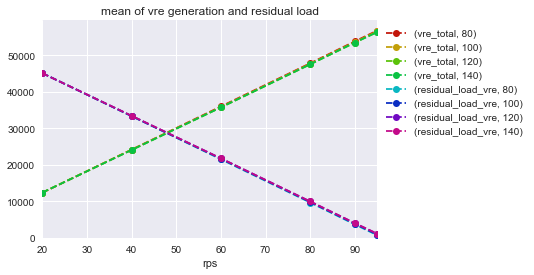

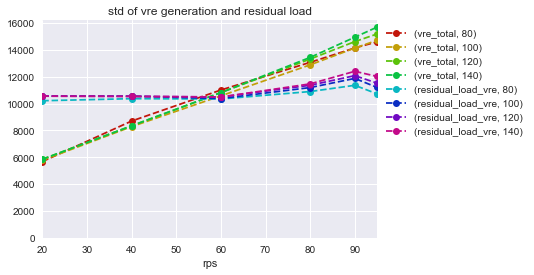

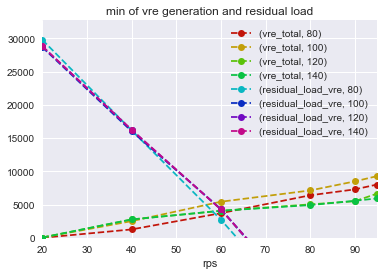

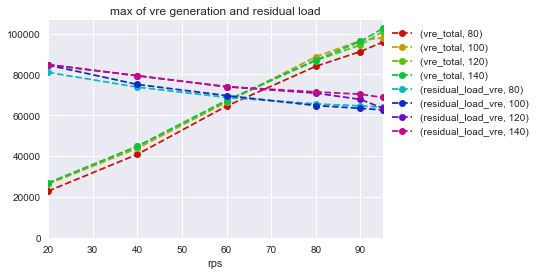

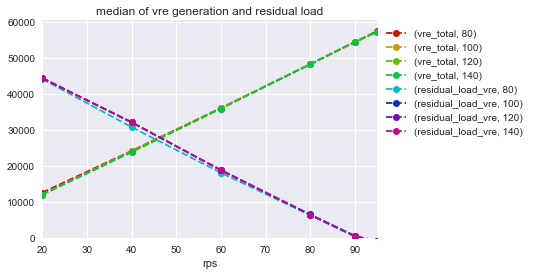

In [12]:
for m in metrics:
    sns.set_palette(sns.hls_palette(8,l=0.4,s=0.9))
    plotdf = statisticalValues[(statisticalValues['metric']==m) & (statisticalValues['waves']==10000)].set_index('rps').pivot(columns='fcost')[columnList]
    if m == '50%':
        m='median'
    plotdf.plot(title = '%s of vre generation and residual load'%m,linestyle='--',marker='o').legend(bbox_to_anchor=(1,1))
    plt.ylim(ymin=0)
    
print('residual loads do not consider storage')